In [1]:
%matplotlib inline

import cv2, matplotlib
import numpy as np
from skimage.morphology import (
    skeletonize,
    skeletonize_3d,
    medial_axis,
    thin,
    local_minima,
    local_maxima,
)
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import distance_transform_edt

from math import sqrt

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = False  # plot every steps

In [2]:
def read_from_csv(filepath):
    if Path(filepath).is_file():

        with open(filepath, "r", newline="", encoding="utf-8-sig") as csvfile:
            listreader = csv.reader(csvfile)
            columns = next(listreader)
            readlist = list(listreader)

    else:
        columns = []
        readlist = []

    return columns, readlist


def read_bgr_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    bgr = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return bgr


def save_bgr_to_image_unicode(bgr, path, ext_to=".png"):
    """workaround for non-ascii filenames"""

    _, numpyarray = cv2.imencode(ext_to, bgr)
    with open(path, "wb") as file:
        file.write(numpyarray)

In [3]:
def align_fp(unit_comb):
    """put the main side to down and entrance to left"""
    bal_moments = cv2.moments(unit_comb[:, :, 4], True)
    ind_moments = cv2.moments(np.bitwise_or.reduce(unit_comb, 2), True)

    ### make it down

    if bal_moments["m00"] > 0:
        if (
            bal_moments["nu02"] / ind_moments["nu02"]
            > bal_moments["nu20"] / ind_moments["nu20"]
        ):
            # print("down")
            pass
        elif (
            bal_moments["m10"] / bal_moments["m00"]
            < ind_moments["m10"] / ind_moments["m00"]
        ):
            # print("left")
            unit_comb = np.rot90(unit_comb, 1)
        else:
            # print("right")
            unit_comb = np.rot90(unit_comb, -1)
    else:
        ldk_moments = cv2.moments(unit_comb[:, :, 2], True)
        if ldk_moments["nu02"] >= ldk_moments["nu20"]:
            # print("down")
            pass
        elif (
            ldk_moments["m10"] / ldk_moments["m00"]
            < ind_moments["m10"] / ind_moments["m00"]
        ):
            # print("left")
            unit_comb = np.rot90(unit_comb, 1)
        else:
            # print("right")
            unit_comb = np.rot90(unit_comb, -1)

    ent_moments = cv2.moments(unit_comb[:, :, 1], True)

    ### put entrance to left
    if (
        ent_moments["m10"] / ent_moments["m00"]
        > ind_moments["m10"] / ind_moments["m00"]
    ):
        # print("flip")
        unit_comb = np.flip(unit_comb, axis=1)

    return unit_comb

In [4]:
from skimage.transform import rescale


def rescale_fp(unit_comb, area, target_ppm=5, trim=True):
    # indoor pixels excluding balcony
    pixels = cv2.countNonZero(np.bitwise_or.reduce(unit_comb, 2) & ~unit_comb[:, :, 4])
    # print(area, pixels)

    scale = sqrt(area * target_ppm ** 2 / pixels)
    # print(scale)

    unit_scale = rescale(unit_comb, scale, mode="edge", multichannel=True)

    if trim:
        indexes = np.where(unit_scale != 0)
        unit_scale = unit_scale[
            min(indexes[0]) : max(indexes[0]) + 1, min(indexes[1]) : max(indexes[1]) + 1
        ]

    return (unit_scale * 255).astype(np.uint8)

In [5]:
def mono_fp(unit_comb):
    """create bit mask image from 
    wall/entrance/LDK/bedroom/balcony/bathroom stacked array"""

    # AREA_WALL = 64
    # AREA_ENTRANCE = 32
    # AREA_LDK = 16
    # AREA_BEDROOM = 8
    # AREA_BALCONY = 4
    # AREA_BATHROOM = 2

    mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)

    # binary cut value
    cut = 0.01 * np.ones(6)
    for i in range(6):
        if cv2.countNonZero(unit_comb[:, :, i]):
            cut[i] = np.average(unit_comb[:, :, i][np.nonzero(unit_comb[:, :, i] > 0)])

    mono = ((unit_comb > cut) * 255).astype(np.uint8) & mask_bits
    mono = np.bitwise_or.reduce(mono, 2)
    return mono

In [6]:
def fp_from_mono(mono):
    """create bit mask image from 
    wall/entrance/LDK/bedroom/balcony/bathroom stacked array"""

    # AREA_WALL = 64
    # AREA_ENTRANCE = 32
    # AREA_LDK = 16
    # AREA_BEDROOM = 8
    # AREA_BALCONY = 4
    # AREA_BATHROOM = 2

    mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)
    mask = np.broadcast_to(mask_bits, (*mono.shape[:2], 6))
    
    unit_comb = (((np.expand_dims(mono,2) & mask) > 0)*255).astype(np.uint8)
    
    return unit_comb

# process files

In [7]:
def read_bgr_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    bgr = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return bgr


def read_from_csv(filepath):
    if Path(filepath).is_file():

        with open(filepath, "r", newline="", encoding="utf-8-sig") as csvfile:
            listreader = csv.reader(csvfile)
            columns = next(listreader)
            readlist = list(listreader)

    else:
        columns = []
        readlist = []

    return columns, readlist

In [8]:
def read_mono_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    mono = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return mono


def save_mono_to_image_unicode(mono, path, ext_to=".png"):
    """workaround for non-ascii filenames"""

    _, numpyarray = cv2.imencode(ext_to, mono)
    with open(path, "wb") as file:
        file.write(numpyarray)

In [9]:
def process_floorplan_mono(
    path_from, area, filename_to, dir_to="/data/fp_img_processed/", ext_to=".png"
):
    try:
        bgr = read_bgr_from_image_unicode(path_from)
        unit_comb = get_unit_mask(bgr)
        unit_comb = rescale_fp(unit_comb, area)
        unit_comb = align_fp(unit_comb)

        mono = mono_fp(unit_comb)
        save_mono_to_image_unicode(mono, dir_to + filename_to + ext_to, ext_to)
    except:
        pass

In [10]:
def pad_fp(fp, width=112, height=112):
    """place the fp at the bottom center of padded image."""
    h, w = np.subtract(fp.shape[:2], (height, width))
    if h > 0:
        fp = fp[h : h + height, :, :]
    if w > 0:
        fp = fp[:, w // 2 : w // 2 + width, :]

    h, w = np.subtract((height, width), fp.shape[:2])
    fp = np.pad(fp, ((max(h, 0), 0), (max(w // 2, 0), max(w - w // 2, 0)), (0, 0)))
    return fp

In [18]:
mono = read_mono_from_image_unicode('/data/fp_img_processed/10001_57B.png')

In [12]:
fp = fp_from_mono(mono)

In [13]:
fp = pad_fp(fp)

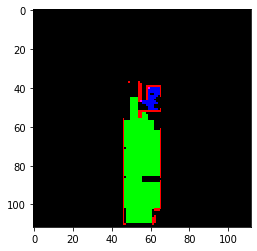

In [14]:
plt.imshow(fp[..., [0, 2, 5]])

In [17]:
np.amax(fp, (0,1))

array([255, 255, 255,   0,   0, 255], dtype=uint8)

In [16]:
np.amin(fp)

0